In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from pathlib import Path

In [2]:
CIRCLES_SOURCE_DIR = '../input/basicshapes/shapes/circles/'
SQUARES_SOURCE_DIR = '../input/basicshapes/shapes/squares/'
TRIANGLES_SOURCE_DIR = '../input/basicshapes/shapes/triangles/'

print(len(os.listdir(CIRCLES_SOURCE_DIR)))
print(len(os.listdir(SQUARES_SOURCE_DIR)))
print(len(os.listdir(TRIANGLES_SOURCE_DIR)))

100
100
100


In [3]:
train_circles_dir = "./shapes/training/circles"
Path(train_circles_dir).mkdir(parents=True, exist_ok=True)
train_squares_dir = "./shapes/training/squares"
Path(train_squares_dir).mkdir(parents=True, exist_ok=True)
train_triangles_dir = "./shapes/training/triangles"
Path(train_triangles_dir).mkdir(parents=True, exist_ok=True)

val_circles_dir = "./shapes/testing/circles"
Path(val_circles_dir).mkdir(parents=True, exist_ok=True)
val_squares_dir = "./shapes/testing/squares"
Path(val_squares_dir).mkdir(parents=True, exist_ok=True)
val_triangles_dir = "./shapes/testing/triangles"
Path(val_triangles_dir).mkdir(parents=True, exist_ok=True)

In [4]:
def split_data(source, training, testing, split_size):
    files = []
    
    for f in os.listdir(source):
        f_path = source + f
        if os.path.getsize(f_path):
            files.append(f)
   
    split_point = int(len(files) * split_size)
    random.shuffle(files)
    train_set = files[:split_point]
    val_set = files[split_point:]
    
    for f in train_set:
        copyfile(os.path.join(source, f), os.path.join(training, f))
        
    for f in val_set:
        copyfile(os.path.join(source, f), os.path.join(testing, f))

split_size = .7
split_data(CIRCLES_SOURCE_DIR, train_circles_dir, val_circles_dir, split_size)
split_data(SQUARES_SOURCE_DIR, train_squares_dir, val_squares_dir, split_size)
split_data(TRIANGLES_SOURCE_DIR, train_triangles_dir, val_triangles_dir, split_size)

In [5]:
print(len(os.listdir(train_circles_dir)))
print(len(os.listdir(train_squares_dir)))
print(len(os.listdir(train_triangles_dir)))
print(len(os.listdir(val_circles_dir)))
print(len(os.listdir(val_squares_dir)))
print(len(os.listdir(val_triangles_dir)))

70
70
70
30
30
30


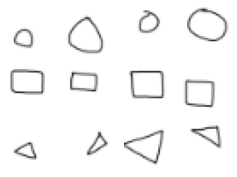

In [6]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 3x4 configuration
nrows = 3
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols, nrows)

pic_index+=4

next_cirlce = [os.path.join(train_circles_dir, fname) 
                for fname in os.listdir(train_circles_dir)[ pic_index-4:pic_index] 
               ]

next_square = [os.path.join(train_squares_dir, fname) 
                for fname in os.listdir(train_squares_dir)[ pic_index-4:pic_index]
               ]

next_triangle = [os.path.join(train_triangles_dir, fname) 
                for fname in os.listdir(train_triangles_dir)[ pic_index-4:pic_index]
               ]

for i, img_path in enumerate(next_cirlce+next_square+next_triangle):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_dir = "./shapes/training"
train_generator = train_datagen.flow_from_directory(train_dir,
                                    batch_size=30,
                                    class_mode='categorical',
                                    target_size=(28, 28))  

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_dir = "./shapes/testing"
validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                batch_size=30,
                                                class_mode  = 'categorical',
                                                target_size = (28, 28))

Found 210 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [8]:
class myCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") >= 0.95:
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCb()

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(3, activation='softmax')  
])

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=200,
                    steps_per_epoch=7,
                    validation_data = validation_generator,
                    validation_steps=3,
                    callbacks=[callbacks],
                    verbose = 2)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

Epoch 1/200
7/7 - 1s - loss: 1.2657 - accuracy: 0.2857 - val_loss: 1.1297 - val_accuracy: 0.3333
Epoch 2/200
7/7 - 0s - loss: 1.1073 - accuracy: 0.3000 - val_loss: 1.0978 - val_accuracy: 0.3333
Epoch 3/200
7/7 - 0s - loss: 1.1051 - accuracy: 0.3429 - val_loss: 1.0921 - val_accuracy: 0.4111
Epoch 4/200
7/7 - 0s - loss: 1.0951 - accuracy: 0.3714 - val_loss: 1.0918 - val_accuracy: 0.4000
Epoch 5/200
7/7 - 0s - loss: 1.1057 - accuracy: 0.3190 - val_loss: 1.0936 - val_accuracy: 0.3333
Epoch 6/200
7/7 - 0s - loss: 1.0959 - accuracy: 0.4000 - val_loss: 1.0821 - val_accuracy: 0.3889
Epoch 7/200
7/7 - 0s - loss: 1.0987 - accuracy: 0.3524 - val_loss: 1.0735 - val_accuracy: 0.5222
Epoch 8/200
7/7 - 0s - loss: 1.1012 - accuracy: 0.3762 - val_loss: 1.0627 - val_accuracy: 0.5556
Epoch 9/200
7/7 - 0s - loss: 1.0744 - accuracy: 0.3952 - val_loss: 1.0363 - val_accuracy: 0.6000
Epoch 10/200
7/7 - 0s - loss: 1.0770 - accuracy: 0.4333 - val_loss: 1.0400 - val_accuracy: 0.5222
Epoch 11/200
7/7 - 0s - loss:

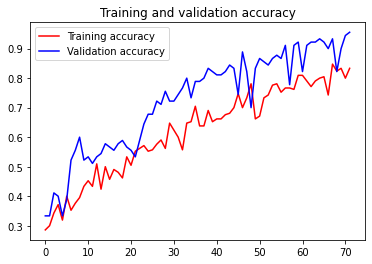

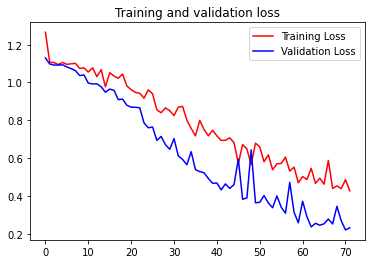

In [10]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()